# Molecule Alpha Simulations

Repository: https://gitlab.com/linumlabs/molecule-system-modelling

**What do we want to investigate given certain assumptions?**

1. Assuming a buy & hold investment behaviour, what tax rate results in reasonable investor break-even period and reaching the funding goal.
2. Given a certain tax rate, what user base and behaviour is needed to reach funding goal in given period.
3. How can we design the bonding curve such that the funding goal is reached within the given time allocated?
4. How can we design the tax such that investors are rewarded fairly, both early and late?
5. How can we fairly dissolve a project and redistribute its collateral when completed?

**In an ideal efficient market, we hope to:**

1. Reach the funding goal in the given period
2. Reward investors fairly
3. Promote further investment

**Funding outcomes can be any of the following, with certain consequences:**

Market creators
1. Funding reached within time period
2. Funding reached before time period
3. Funding not reached

Investors
1. Investors reach ROI
2. Investors make a profit
3. Investors make a loss

## Module imports

In [33]:
import sys
sys.path.append("../lib/python3.7/site-packages")

import networkx as nx

import matplotlib.pyplot as plt
%matplotlib inline
import math
from scipy.optimize import fsolve
import scipy.integrate as integrate
from datetime import timedelta

from decimal import Decimal
import numpy as np
import pandas as pd
from pynverse import inversefunc

import ipywidgets as widgets
from IPython.display import display

from abc import ABC, abstractmethod
from enum import Enum, auto
from functools import partial
import random
import uuid
import json

import plotly.plotly as py
import plotly.graph_objs as go
import plotly
plotly.tools.set_credentials_file(username='BenjaminScholtz', api_key='8HheLHWEyoXDuLOiQ4ZO')

In [34]:
params = {
    'tax_rate': [.05], # percentage
#     'funding_period': [6], # months
#     'funding_goal': [1_000_000], # dollars
    'max_holdings': [100_000],
}

# TODO: configure network

initial_conditions = {
    'investors': [100], # total for funding round
#     'supporters': []
    'trading_balance': [10_000], # dollars
}

projects = 1
max_investors_per_project = 20
investment_size = 1000.0

default_gradient = 1/17_500.0
default_shift = 0.5

sigmoid_inflection = 80
sigmoid_slope = 1/20

blocks_per_year = 2102400
blocks_per_month = blocks_per_year/12
blocks_per_day = blocks_per_year/365

time_steps = int(6*30) # approx. 30 days per month

time_steps

180

In [35]:
# monotonically increasing polynomial function
def bonding_function(x, m=default_gradient, c=default_shift):
#     return np.multiply(m, x) + c
    C = 10
    a = 0.001
    return C * (1 - np.exp(-a*x)) + 1

def tax_function(x, m=default_gradient, c=default_shift):
#     return np.multiply(m, x) + c*(1 - params['tax_rate'][0])
    C = 10
    a = 0.001
    return C * (1 - np.exp(-a*x))

# this is essentially numerical integration
#     return [np.sum(bonding_function(x[:index])) for index,_ in enumerate(x)]

def integral_function(x):
    return integrate.quad(lambda i: bonding_function(i), 0, x)[0]

# invariant function
def collateral_pool(x):
    return [integral_function(x[index]) for index,_ in enumerate(x)]
    
def inverse_integral_function(x):
    func = inversefunc(integral_function)
    return func(x)

def final_collateral(x):
    return integrate.quad(lambda i: bonding_function(i), x[0], x[-1])

def vault_pool(x):
    return np.subtract(collateral_pool(x), [integrate.quad(lambda i: tax_function(i), x[0], x[index])[0] for index,_ in enumerate(x)])

def investor_pool(x):
    return np.subtract(collateral_pool(x), vault_pool(x))

# Contract functions

def price_to_mint(x_T, total_supply, pool_balance, gradient):
    return integral_function(total_supply + x_T) - pool_balance

def reward_for_burn(x_T, total_supply, pool_balance):
    return pool_balance - integral_function(total_supply - x_T)

def collateral_to_token_buying(x_D, total_supply):
    return inverse_integral_function(integral_function(total_supply) + x_D) - total_supply

def collateral_to_token_selling(x_D, total_supply):
    try:
        return total_supply - inverse_integral_function(integral_function(total_supply) - x_D)
    except ValueError:
        return 0

In [36]:
a = integral_function(50)
inverse_integral_function(a)

array(50.00000003)

In [37]:
bonding_function(10000) - tax_function(10000)

0.025000000000000133

In [38]:
x = np.linspace(0,10_000,10_00)

y = bonding_function(x)
t = tax_function(x)
c = collateral_pool(x)
v = vault_pool(x)
i = investor_pool(x)

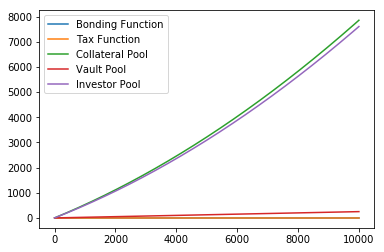

In [39]:
plt.plot(x, y, label='Bonding Function')
plt.plot(x, t, label='Tax Function')
plt.plot(x, c, label='Collateral Pool')
plt.plot(x, v, label='Vault Pool')
plt.plot(x, i, label='Investor Pool')
plt.legend(loc='upper left')
plt.show()

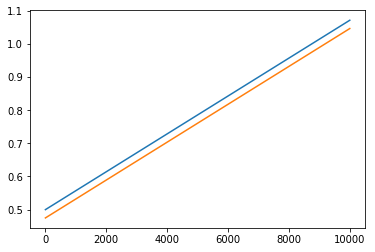

In [40]:
# Bonding function and tax (sell) function
plt.plot(x, y, x, t)
plt.show()

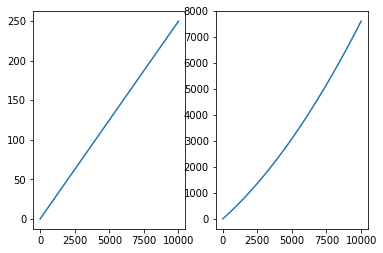

In [41]:
# Vault and investor pool
fig, axs = plt.subplots(1,2)

axs[0].plot(x, v)
axs[1].plot(x, i)

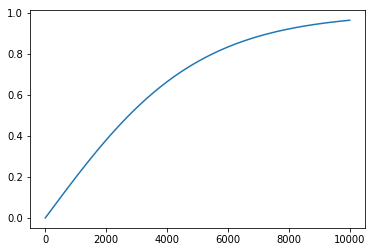

In [42]:
token_supply = 10_000
x = np.linspace(0,token_supply,1000)
y = np.tanh(x/(token_supply*.5))
plt.plot(x, y)
plt.show()

Given the funding goal and period, what parameters will help us reach that goal?

1. Tax rate
2. Total investment
3. Investor activity
4. Bonding curve

## Utility Functions

In [43]:
def id():
    return uuid.uuid4().int & (1<<64)-1

def bollinger_bands(value, window_size, num_of_std):

    rolling_mean = value.rolling(window=window_size).mean()
    rolling_std  = value.rolling(window=window_size).std()
    upper_band = rolling_mean + (rolling_std*num_of_std)
    lower_band = rolling_mean - (rolling_std*num_of_std)

    return rolling_mean, upper_band, lower_band

def get_node_ids_of_type(network, _type):
    return [x for x,y in network.nodes(data=True) if y['_type']==_type]

def pad(vec, length,fill=True):

    if fill:
        padded = np.zeros(length,)
    else:
        padded = np.empty(length,)
        padded[:] = np.nan
        
    for i in range(len(vec)):
        padded[i]= vec[i]
        
    return padded

def make2D(key, data, fill=False):
    maxL = data[key].apply(len).max()
    newkey = 'padded_'+key
    data[newkey] = data[key].apply(lambda x: pad(x,maxL,fill))
    reshaped = np.array([a for a in data[newkey].values])
    
    return reshaped

## Custom cadCAD type classes

In [44]:
class StateType(Enum):
    @classmethod
    def initial_state(cls):
        _members = {}
        for item in cls.__members__:
            _members[cls[item]] = 0
        return _members
    
    def initial_conditions(cls):
        print("initial_conditions not implemented")

class ActionsType(Enum):
    def __init__(self, *args, **kwargs):
        pass
    
    def method(self, *args):
        method = getattr(self.__class__, '_%s' % self.name)
        return method(*args)

class PoliciesType:
    def list(self):
        policies = [func for func in dir(self) 
                    if (callable(getattr(self, func)) 
                        and func != 'list' 
                        and func.find('_'))]
        returnVal = {}
        for func in policies: returnVal[func] = getattr(self, func)
        return returnVal

## States

### Configure graph

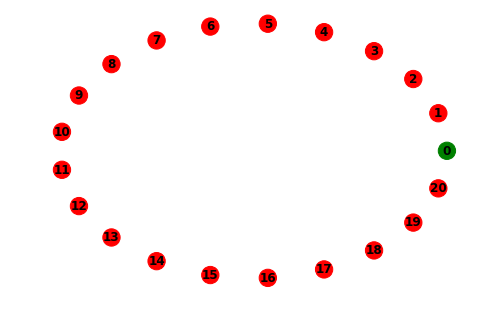

In [61]:
class Vault:
    def __init__(self):
        self.reserve = 0
        
class BondingCurve:
    def __init__(self):
        self.bonded_tokens = 0
        self.reserve = 0

class Project:
    def __init__(self):
        self.status = 'project'
        self.vault = Vault()
        self.bonding_curve = BondingCurve()
        self.funding_goal = 1_000_000
        self.funding_period = 6 # months
        self.tax_rate = .05
    
class Investor:
    def __init__(self):
        self.status = 'validated'
        self.trading_balance = 10_000 # dollars
        self.invested = 0
        self.bonded_tokens = 0
        self.estimated_value = 0 # dollar value of tokens
        self.sentiment = 1 # 1 being hold indefinitely, 0 being sell immediately... tbd

G = nx.Graph()
color_map = []

for project in range(projects):
    color_map.append('green')
    G.add_node(project, data=Project(), _type='project')
    
for investor in range(max_investors_per_project):
    color_map.append('red')
    G.add_node(investor + 1, data=Investor(), _type='investor')

nx.draw_kamada_kawai(G, node_color=color_map, font_weight='bold', with_labels=True) # with_labels=True

class NetworkState(StateType):
    network = auto()
    
    @classmethod
    def initial_conditions(cls):
        return {
            cls.network: G,
        }

In [46]:
class StateAgregated(StateType):
    pool_balance = auto()
    
    @classmethod
    def initial_conditions(cls):
        return {
            **cls.initial_state()
        }

## Actions

In [47]:
class ActionsExogenous(ActionsType):
    new_investors = auto()
    investment_pool_generator = auto()
    
    @classmethod
    def _new_investors(cls, _g, step, sL, s, _input):        
        network: nx.Graph = s[NetworkState.network]

        projects = get_node_ids_of_type(network, 'project')
        project = projects[0]
        investors = get_node_ids_of_type(network, 'investor')

        currently_invested = list(network.neighbors(project))
        
        number_of_investors = max_investors_per_project/(1 + math.pow(math.e, -(s['timestep'] - sigmoid_inflection)*sigmoid_slope))
        number_of_investors = max(math.floor(number_of_investors), 0)

        new_investors = investors[len(currently_invested) : number_of_investors]

        for index in new_investors:
            network.node[index]['data'].status = 'invested'
            network.add_edge(project, index)
        
        return (NetworkState.network, network)
    
    @classmethod
    def _investment_pool_generator(cls, _g, step, sL, s, _input):
        y = StateExogenous.tx_volume
        x = s[StateExogenous.tx_volume]*(1+2*eta*np.random.rand()*(1-s[StateExogenous.tx_volume]/tampw))
        return (y, x)

class TradingActions(ActionsType):
    perform_trades = auto()
    
    @classmethod
    def _perform_trades(cls, _g, step, sL, s, _input):
        network: nx.Graph = s[NetworkState.network]

        projects = get_node_ids_of_type(network, 'project')
        project = projects[0]
        investors = get_node_ids_of_type(network, 'investor')
        
        currently_invested = list(network.neighbors(project))
        
        for index in currently_invested:
            project = projects[0]
            
            project_node = network.node[project]
            investor_node = network.node[index]
            
            vault = project_node['data'].vault
            bonding_curve: BondingCurve = project_node['data'].bonding_curve
            
            collateral_to_invest = investment_size
            collateral_tax = collateral_to_invest * project_node['data'].tax_rate
            collateral_less_tax = collateral_to_invest - collateral_tax
            
            if investor_node['data'].trading_balance - collateral_to_invest >= 0:
                tokens_buy = collateral_to_token_buying(collateral_less_tax, bonding_curve.bonded_tokens)

                bonding_curve.bonded_tokens += tokens_buy
                bonding_curve.reserve += collateral_less_tax

                vault.reserve += collateral_tax

                investor_node['data'].trading_balance -= collateral_to_invest
                investor_node['data'].invested += collateral_to_invest
                investor_node['data'].bonded_tokens += tokens_buy
                investor_node['data'].estimated_value = reward_for_burn(investor_node['data'].bonded_tokens, bonding_curve.bonded_tokens, bonding_curve.reserve)
            
        return (NetworkState.network, network)
    
class UpdateActions(ActionsType):
    update_balances = auto()
    
    @classmethod
    def _update_balances(cls, _g, step, sL, s, _input):
        community_state = s[State.community_state]
        members = community_state.members
        
        for member in members:
            member.user_balance = reward_for_burn(
            member.user_supply, community_state.total_supply, community_state.pool_balance, s[State.gradient])
            
        return (State.community_state, community_state)
    
class MetricActions(ActionsType):
    agregate = auto()
    pool_balance = auto()
    
    @classmethod
    def _pool_balance(cls, _g, step, sL, s, _input):
        y = StateAgregated.pool_balance
        if _input[cls.agregate] == 1:
            x = s[State.community_state].pool_balance
        else:
            x = s[StateAgregated.pool_balance]
        return (y, x)

## Actions

In [48]:
class MetricPolicies(PoliciesType):
    def agregate(self, params, step, sL, s):
        return({MetricActions.agregate: 1})
    
class Policies(PoliciesType):
    #def __init__(self):
        
    def update_balances(self, params, step, sL, s):
        return({UpdateActions.update_community_state: True})

## cadCAD Model Initialization

In [49]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# Settings of general simulation parameters, unrelated to the system itself
# `T` is a range with the number of discrete units of time the simulation will run for;
# `N` is the number of times the simulation will be run (Monte Carlo runs)
# In this example, we'll run the simulation once (N=1) and its duration will be of 10 timesteps
# We'll cover the `M` key in a future article. For now, let's leave it empty
from cadCAD.configuration.utils import config_sim

simulation_parameters = config_sim({
    'T': range(time_steps),
    'N': 1,
    'M': params
})
simulation_parameters

[{'N': 1, 'T': range(0, 180), 'M': {'tax_rate': 0.05, 'max_holdings': 100000}}]

In [50]:
# %%capture

ts_format = '%Y-%m-%d %H:%M:%S'
t_delta = timedelta(days=30, minutes=0, seconds=0)
def time_model(_g, step, sL, s, _input):
    y = 'time'
    x = ep_time_step(s, dt_str=s['time'], fromat_str=ts_format, _timedelta=t_delta)
    return (y, x)

exogenous_states = {
#     'time': time_model
}
env_processes = {}

initial_state = {
    **NetworkState.initial_conditions(),
#     **StateExogenous.initial_conditions(),
#     **StateAgregated.initial_conditions()
}

metric_policies = MetricPolicies()
policies = Policies()

partial_state_update_blocks = [
    # Exogenous inputs
    {
        'policies': {},
        'variables': {
            NetworkState.network: ActionsExogenous.new_investors.method,
        }
    },
    {
        'policies': {},
        'variables': {
            NetworkState.network: TradingActions.perform_trades.method,
        }
    }
]

## Model Simulation

In [51]:
from cadCAD.configuration import append_configs
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# The configurations above are then packaged into a `Configuration` object
append_configs(
    initial_state=initial_state, #dict containing variable names and initial values
    partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
    sim_configs=simulation_parameters, #dict containing simulation parameters
#     raw_exogenous_states=exogenous_states,
#     env_processes=env_processes
)

In [52]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# from cadCAD.configuration import Configuration
from cadCAD import configs
# from cadCAD.configuration import configs
import cadCadFunctions as c2F
from tabulate import tabulate
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The configurations above are then packaged into a `Configuration` object
# config = Configuration(initial_state=initial_state, #dict containing variable names and initial values
#                        partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
#                        sim_config=simulation_parameters, #dict containing simulation parameters
#                        raw_exogenous_states=exogenous_states,
#                        env_processes=env_processes,
#                       )

from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
exec_mode = ExecutionMode()
exec_context = ExecutionContext(context=exec_mode.single_proc)
run = Executor(exec_context=exec_context, configs=configs) # Pass the configuration object inside an array
raw_result, tensor = run.execute() # The `main()` method returns a tuple; its first elements contains the raw results

%matplotlib inline
from matplotlib import cm
import pandas as pd

single_proc: [<cadCAD.configuration.Configuration object at 0x7f8249891208>, <cadCAD.configuration.Configuration object at 0x7f82498913c8>, <cadCAD.configuration.Configuration object at 0x7f8249969390>, <cadCAD.configuration.Configuration object at 0x7f8249969400>, <cadCAD.configuration.Configuration object at 0x7f82481fcc18>]
[<cadCAD.configuration.Configuration object at 0x7f8249891208>, <cadCAD.configuration.Configuration object at 0x7f82498913c8>, <cadCAD.configuration.Configuration object at 0x7f8249969390>, <cadCAD.configuration.Configuration object at 0x7f8249969400>, <cadCAD.configuration.Configuration object at 0x7f82481fcc18>]


In [53]:
# import sys

# sys.setrecursionlimit(5000)

In [54]:
# i = 0
# verbose = False
# results = {}
# for raw_result, tensor_field in run.execute():
#     result = pd.DataFrame(raw_result)
#     if verbose:
#         print()
#         print(f"Tensor Field: {type(tensor_field)}")
#         print(tabulate(tensor_field, headers='keys', tablefmt='psql'))
#         print(f"Output: {type(result)}")
#         print(tabulate(result, headers='keys', tablefmt='psql'))
#         print()
#     results[i] = {}
#     results[i]['result'] = result
#     results[i]['simulation_parameters'] = simulation_parameters[i]
#     i += 1

In [55]:
# results[0]['result']

KeyError: 0

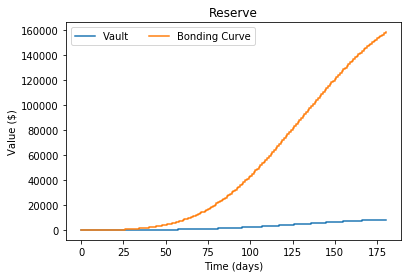

In [56]:
df = pd.DataFrame(raw_result)

df['vault_reserve'] = df[NetworkState.network].apply(lambda g: np.array([g.node[j]['data'].vault.reserve for j in get_node_ids_of_type(g, 'project')]))
df['bonding_curve_reserve'] = df[NetworkState.network].apply(lambda g: np.array([g.node[j]['data'].bonding_curve.reserve for j in get_node_ids_of_type(g, 'project')]))

# df['conviction'] = df.network.apply(lambda g: np.array([g.nodes[j]['conviction'] for j in get_nodes_by_type(g, 'proposal') if g.nodes[j]['status']=='candidate']))
# df['candidate_count'] = df.network.apply(lambda g: len([j for j in get_nodes_by_type(g, 'proposal') if g.nodes[j]['status']=='candidate']))

plt.plot(df.timestep, df['vault_reserve'])
plt.plot(df.timestep, df['bonding_curve_reserve'])
plt.title('Reserve')
plt.ylabel('Value ($)')
plt.xlabel('Time (days)')
plt.legend(['Vault', 'Bonding Curve'], ncol = 2)

# df['investor_balance'] = df[NetworkState.network].apply(lambda g: [g.node[j]['data'].trading_balance 
#                                                                             for j in get_node_ids_of_type(g, 'investor') if j in list(g.neighbors(0))][0])
# # plt.plot(df.timestep, df['investor_balance'])
# df['investor_balance'].plot()

[   0.         2299.04348887 2040.54980075 1867.24272098 1740.65996155
 1640.92826521 1564.66348451 1508.00737291 1455.51578495 1407.10721895
 1362.56310962 1249.47750133 1165.62542816 1087.04704357 1013.17907631
  926.77529967  830.54682476  726.89751426  604.78258484  421.97154876
    0.        ]


/nix/store/cg057x30qnm94qfagxcqhqgfv0n70758-python3-3.7.2-env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning:

isinstance(..., numbers.Number)



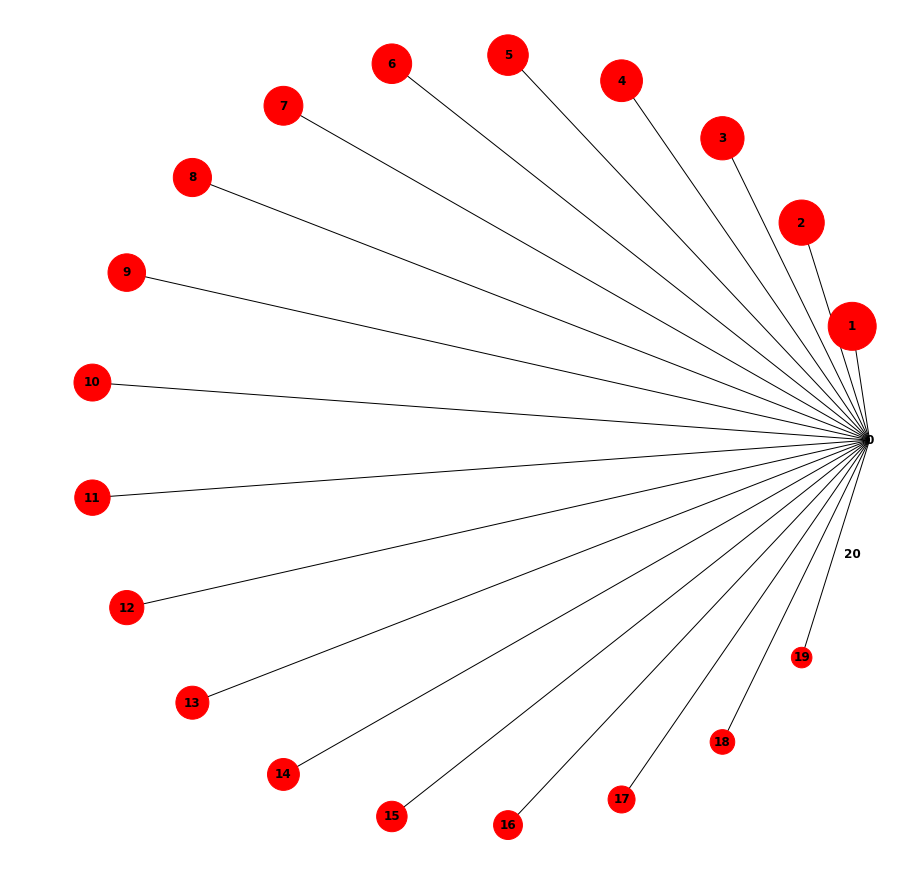

In [57]:
time_step = 360

df['investor_balance'] = df[NetworkState.network].apply(lambda g: [g.node[j]['data'].estimated_value 
                                                                            for j in get_node_ids_of_type(g, 'investor')])

node_sizes = np.append([0], np.divide(df['investor_balance'][time_step], 10))
print(node_sizes)
plt.figure(1,figsize=(12,12)) 
nx.draw_circular(df[NetworkState.network][360], node_color=color_map, node_size=node_sizes, font_weight='bold', with_labels=True) # with_labels=True

# print(type(df[NetworkState.network]))
# df = pd.DataFrame(raw_result)
# print(df[NetworkState.network].apply(lambda g: g.nodes))

# print(df['investor_balance'])

In [58]:
rdf = df[df.substep==2].copy()
# rdf.head(10).append(rdf.tail(10))

Text(0, 0.5, 'share of estimated valuation')

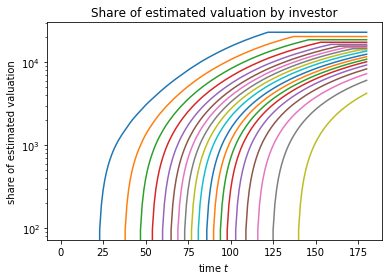

In [59]:
plt.semilogy(rdf.timestep, make2D('investor_balance', rdf))
plt.title('Share of estimated valuation by investor')
plt.xlabel('time $t$')
plt.ylabel('share of estimated valuation')

# Continuous Taxation

Tax rate set at a percentage per time period. For example 5% per month. See below re. block time.

* Investigate harburger tax

From the Compound interest rate model:

See https://github.com/compound-finance/compound-money-market/blob/master/contracts/InterestRateModel.sol & https://github.com/compound-finance/compound-money-market

```    /**
      * @notice Gets the current supply interest rate based on the given asset, total cash and total borrows
      * @dev The return value should be scaled by 1e18, thus a return value of
      *      `(true, 1000000000000)` implies an interest rate of 0.000001 or 0.0001% *per block*.
      * @param asset The asset to get the interest rate of
      * @param cash The total cash of the asset in the market
      * @param borrows The total borrows of the asset in the market
      * @return Success or failure and the supply interest rate per block scaled by 10e18
*/
```

They use an interest rate based on `uint constant blocksPerYear = 2102400;`

Probably the best explanation of continuous tokens: https://yos.io/2018/11/10/bonding-curves/

First proposal:

1. Use a continuous token model, with a negative exponential function
2. A negative exponential function should dampen the effect seen in Protea where early investors are unfairly rewarded
3. When it comes time to dissolve the market, the connector weight can be set to 100% - essentially making all tokens the same price, and making the market entirely collateralized
4. A tax can be calculated as a function of block time, collateral pool size, funding goal, and funding period - optimized to reach a funding goal in the given period, no matter what

Assumptions:

1. You want to tax early investors less than late investors - this coincides with having a progressive tax
2. Using a continuous token model you could continuously decollateralize the market more easily

Tax rate should vary between r_min and r_max. An ideal curve for this would be a generalized logistic function with A = -1, let's call it G()
https://en.wikipedia.org/wiki/Generalised_logistic_function

G() where r_min is at the origin and r_max at the assymptote.

When the connector weight is 100%, all investors are taxed equally...? When the connector weight is any less than 100%, early investors are effectively taxed less.
When there is less activity, ideally the tax rate should be lower, to incetivize new investors. If the tax rate is based on the collateral pool size, we need to be careful not to make the funding goal a never reachable assymptote. Given a certain market size, let's calculate the continuous tax rate such that the funding goal is reached in at least the given period.

# Investor Story

At this stage, with a limited understanding of the investment behaviour of our target market, and even the size - we're better off simulting the user base as a monotonically increasing curve that approaches a reasonable assymptote. We can decide what the best and worst case scenarios are and simulate these - this will be what the asymptotic total investment value is, and how long it take to reach it.

We can theorize that given 100 investors, with a fund of 100_000 each to invest, we could end up with a total investment pool of 10_000_000 within an ideal period of 6 months. Worst case we only reach 20% of our invesor market, or 20% of the theoretical total investment pool, and we end up with 2_000_000. We can adjust how we simulate this or what the best and worse case scenarios are, but basically we should create an investor story and work from that, rather than digging into investor behaviour too deeply.

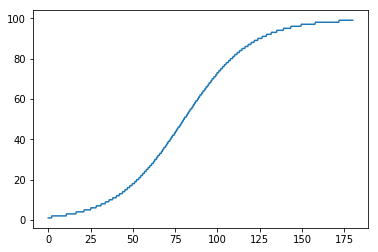

In [60]:
max_user_base = 100

sigmoid_inflection = 80
sigmoid_slope = 1/20

x = np.linspace(0, 180, 500)
y = np.divide(max_user_base, (1 + np.power(np.e, -np.multiply(np.subtract(x, sigmoid_inflection), sigmoid_slope))))
y = np.floor(y)
y[y < 0] = 0

plt.plot(x, y)
plt.show()

# y = StateExogenous.tx_volume
# x = s[StateExogenous.tx_volume]*(1+2*eta*np.random.rand()*(1-s[StateExogenous.tx_volume]/tampw))
# return (y, x)

# x = np.linspace(0,token_supply,1000)
# y = np.tanh(x/(token_supply*.5))
# plt.plot(x, y)
# plt.show()